In [ ]:
import os, sys
sys.path.append("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
from tqdm import tqdm
import math, json, io, textwrap
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch
lt.monkey_patch()
from safetensors.torch import load_file, save_file

from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import vae_decode, vae_encode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.hv_train_network import collator_class, load_prompts
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.utils.bbox_utils import get_bbox_from_mask, get_mask_from_bboxes, draw_bboxes, get_facebbox_from_bbox
from musubi_tuner.wan_generate_video import merge_lora_weights
from preproc_utils import preproc_image, preproc_mask, postproc_imgs
from preproc_utils import get_text_preproc, prepare_control_inputs_for_entity, get_all_kwargs_from_opens2v_metapath
from attn_utils import get_pltplot_as_pil, get_text_inds_from_dict, get_attn_map
from viz_utils import printable_metadata, return_total_visualization

sys.path.append("/home/yo564250/workspace/whisperer/utils")
from img_utils import convert_from_qwen2vl_format
from vistory_utils import StoryDataset

vistory_dataset_path = Path("/groups/chenchen/patrick/ViStoryBench/ViStoryBench")
vistory_dataset = StoryDataset(vistory_dataset_path)

device = torch.device('cuda')

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is not installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention


/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
2025-09-09 20:25:15.835880397 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 1697206, index: 4, mask: {20, 52, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-09-09 20:25:15.835876398 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 1697224, index: 22, mask: {29, 61, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-09-09 20:25:15.835899513 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 1697221, index: 19, mask: {17, 49, }, error cod

In [2]:
%%time

main_path = Path("/home/yo564250/workspace/ComfyUI/models/")
dit_path = "diffusion_models/FramePackI2V_HY_bf16.safetensors"
vae_path = "vae/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "text_encoders/clip_l.safetensors"
image_encoder_path = "clip_vision/sigclip_vision_patch14_384.safetensors"
# lora_path = "/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/outputs/training/idmask_control_lora/idmask_control_lora_test3.safetensors"
# lora_path = '../../outputs/training/idmask_control_lora/idmask_control_lora_test3.safetensors'
lora_path = '../../outputs/training/idmask_control_lora_wrope_v1/idmask_control_lora_wrope_v1_4.safetensors'
# lora_path = None

model = load_packed_model(device, main_path / dit_path, 'sageattn', device, has_image_proj=False)
model.to(device)
model.eval().requires_grad_(False)

if lora_path is not None:
    merge_lora_weights(lora_framepack, model, 
        SimpleNamespace(
            lora_weight = [lora_path], lora_multiplier = [1.0], 
            include_patterns=None, exclude_patterns=None, lycoris=None, save_merged_model=False
        ), 
    device, None)

vae = load_vae(str(main_path / vae_path), 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=str(main_path / text_encoder1_path)), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=str(main_path / text_encoder2_path)))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=str(main_path / image_encoder_path)))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v1/idmask_control_lora_wrope_v1_4.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules

CPU times: user 23.3 s, sys: 15.5 s, total: 38.9 s
Wall time: 4min 17s


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 2678, 3072] bf16 n=8226816 (16Mb) x∈[-16.875, 19.250] μ=-0.017 σ=0.816 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 106, 3072] bf16 n=325632 (0.6Mb) x∈[-3.552e+03, 478.000] μ=0.028 σ=10.750 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-9.375, 20.000] μ=-0.107 σ=0.961 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 2784, 2784] bf16 n=7750656 (15Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 2678, 256] n=685568 (2.6Mb) x∈[-1.000, 1.000] μ=0.339 σ=0.621 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 2040, 256] n=522240 (2.0Mb) x∈[-1.000, 1.000] μ=0.338 σ=0.621 cuda:0, tensor[1, 638, 256] n=163328 (0.6Mb) x∈[-1.000, 1.000] μ=0.342 σ=0.619 cuda:0], 'clean_latents': [(0, 638)], 'noise': [(638, 2678)], 'text_embeddings': [(2678, 2783), (2783, 2784)]})


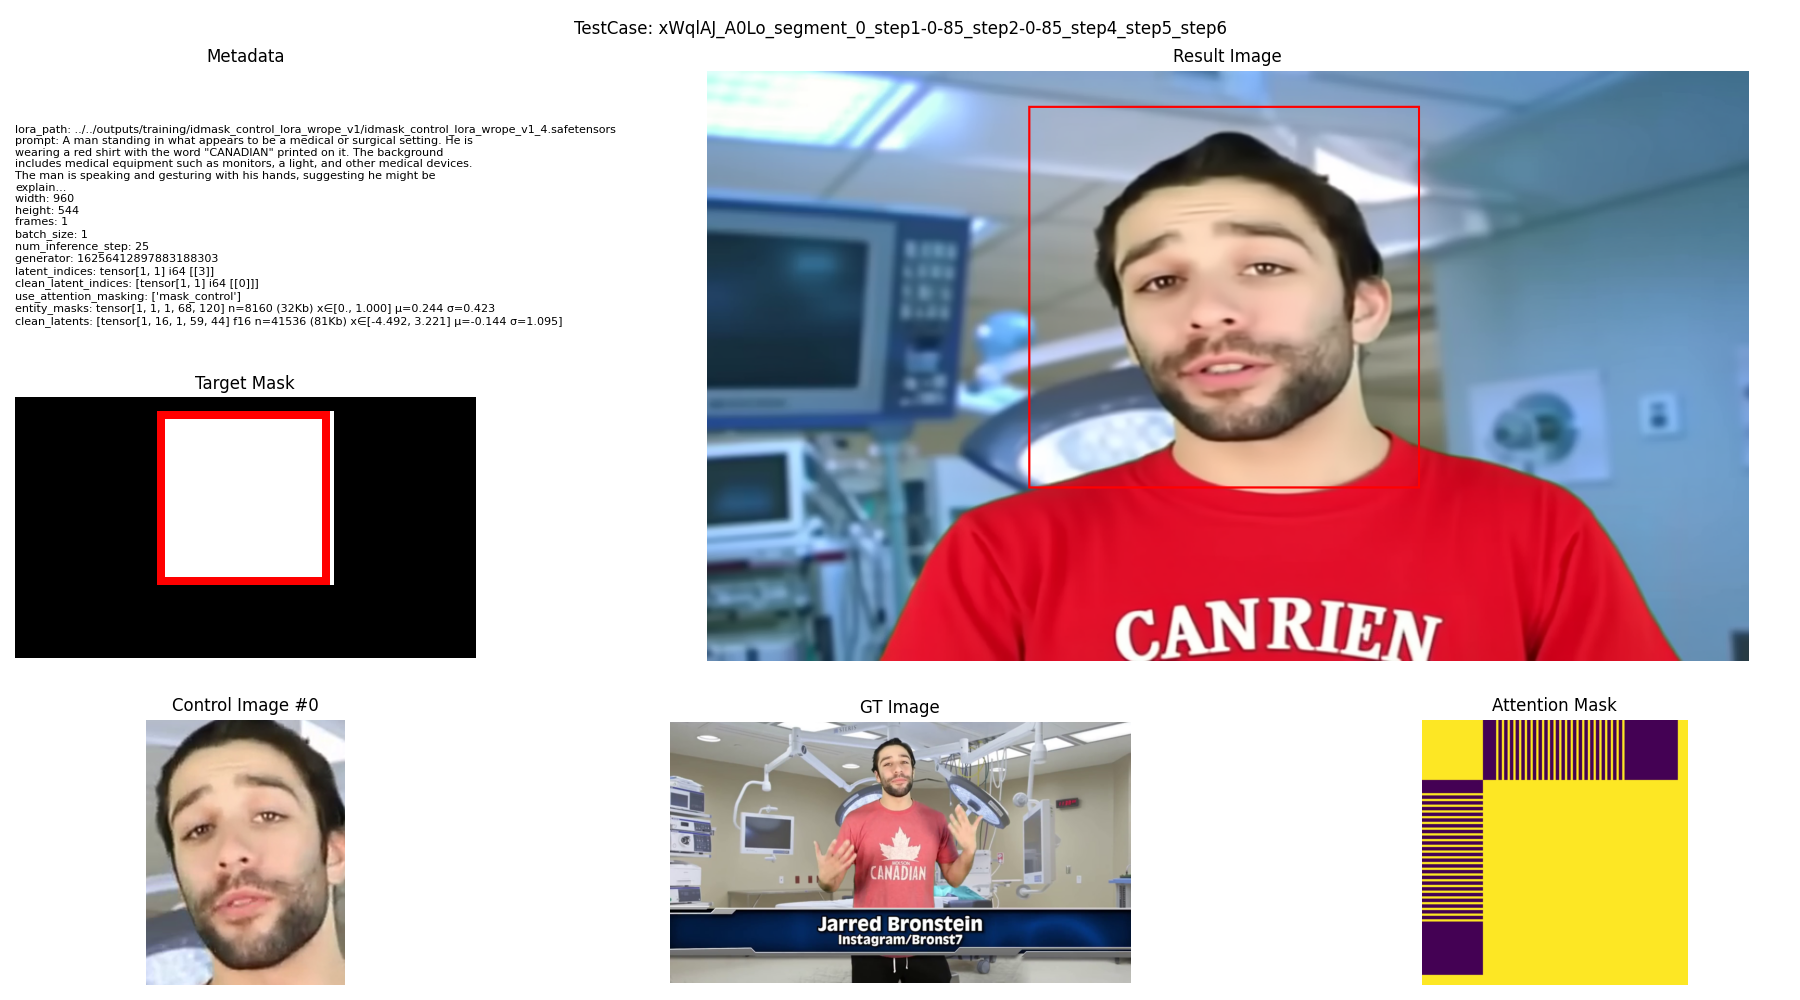

In [8]:
dset_path = Path("/groups/chenchen/patrick/OpenS2V-Nexus/datasets")
dset_name = "test3_2"
# name = "RH9DTExtz1s_segment_55_step1-0-73_step2-0-73_step4_step5_step6"
# name = "zYwOTomP5EE_segment_59_step1-12-125_step2-12-113_step4_step5_step6"
name = "xWqlAJ_A0Lo_segment_0_step1-0-85_step2-0-85_step4_step5_step6"
# name = "qo_3QHD9gYQ_segment_4_step1-0-173_step2-0-173_step4_step5_step6"
el_path = dset_path / f"{dset_name}/{name}"

width, height = 960, 544
seed = -1
total_kwargs, total_nps = get_all_kwargs_from_opens2v_metapath(
    el_path, steps=25, seed=seed, width=width, height=height, 
)
text_kwargs = get_text_preproc(
    total_kwargs['prompt'], text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[""], device=device)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    total_kwargs['control_image_paths'], total_nps['bboxes'], width, height, vae,
    c_width=256, c_height=None, control_indices=[0], latent_indices=[3], 
    adjust_custom_wh=True, mode="provided_size_mid_x")

attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)
result_img = draw_bboxes(Image.fromarray(postproc_imgs(results, vae)[0]), total_nps['bboxes'])

mask = Image.fromarray(total_nps['entitymask_nps'][0]).convert("RGB")
mask = np.asarray(draw_bboxes(mask, control_kwargs['clean_latent_bboxes'][0]))
meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization(name, meta_str, np.asarray(result_img), 
                                        attn_mask, control_nps[0], mask, total_nps['gt_np'])
result_img

  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 1044, 3072] bf16 n=3207168 (6.1Mb) x∈[-15.625, 18.000] μ=-0.015 σ=0.715 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 21, 3072] bf16 n=64512 (0.1Mb) x∈[-4.576e+03, 484.000] μ=-0.031 σ=20.500 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.875, 19.000] μ=-0.105 σ=0.930 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 1065, 1065] bf16 n=1134225 (2.2Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 1044, 256] n=267264 (1.0Mb) x∈[-1.000, 1.000] μ=0.369 σ=0.603 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 900, 256] n=230400 (0.9Mb) x∈[-1.000, 1.000] μ=0.370 σ=0.602 cuda:0, tensor[1, 144, 256] n=36864 (0.1Mb) x∈[-1.000, 1.000] μ=0.360 σ=0.608 cuda:0], 'clean_latents': [(0, 144)], 'noise': [(144, 1044)], 'text_embeddings': [(1044, 1065)]})


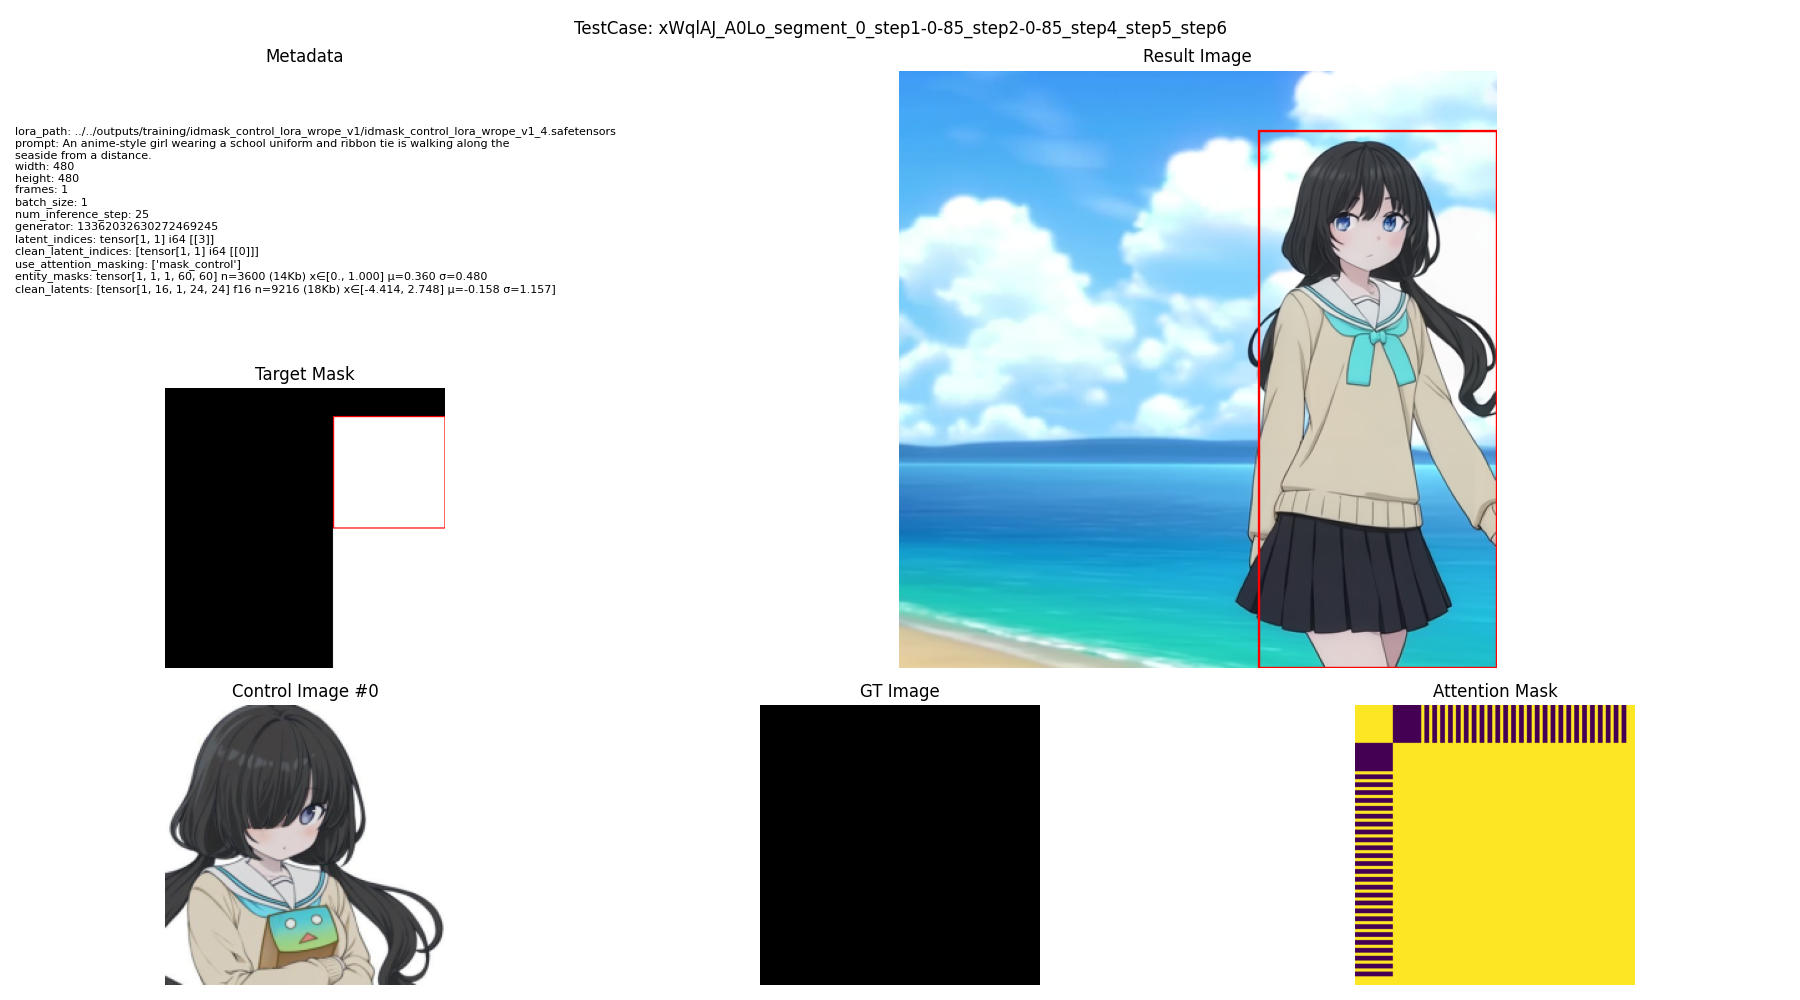

In [17]:
prompt = 'An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance.'
height, width = 480, 480

entity_prompts = ["An anime-style girl wearing a school uniform and ribbon tie"]
entity_bboxes = [[ 0.6, 0.1, 1.0, 1.0 ]]

control_image_paths = ["../../docs/fg_sample.jpg"]
target_index = [3]
control_indices = [0]

text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

entitymask_nps = [get_mask_from_bboxes(entity_bboxes, width, height)]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 1)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_image_paths, entity_bboxes, width, height, vae,
    control_indices=control_indices, latent_indices=target_index, 
    adjust_custom_wh=True)

num_inference_steps=25
seed = np.random.randint(2**31)
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)
cache_layers = ['transformer_blocks.2', 'transformer_blocks.8', 'transformer_blocks.14']

total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'real_guidance_scale': 1.0, 'distilled_guidance_scale': 10.0, 'guidance_rescale': 0.0, 'shift': None,
    'num_inference_step': num_inference_steps, 'generator': generator,
    'device': device, 'dtype': torch.bfloat16,
    'cache_results': True, 'cache_layers': [], 'use_attention_masking': ['mask_control'],
    'entity_masks': entity_masks,
    'control_image_paths': control_image_paths
}
attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results,vae)[0])
result_img = draw_bboxes(result_img, entity_bboxes)
# result_img = draw_bboxes(result_img, control_kwargs['clean_latent_bboxes'].numpy()[0], color=(0,0,255))

mask = Image.fromarray(entitymask_nps[0]).convert("RGB")
mask = np.asarray(draw_bboxes(mask, control_kwargs['clean_latent_bboxes'][0]))
meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization(name, meta_str, np.asarray(result_img), 
                                        attn_mask, control_nps[0], mask, 
                                        np.zeros((height, width, 3), dtype=np.uint8))
result_img

In [ ]:
author_output_dir = Path("/home/yo564250/workspace/whisperer/outputs/20250810_093731")
author_output_dir = vistory_dataset_path / "02/gen_layouts/20250909_102528"
shot_num = 3

case_config = json.loads((author_output_dir / "config.json").read_text())
layout = json.loads((author_output_dir / "pose_layout.json").read_text())[f'[PANEL-{shot_num}]']
rel_w, rel_h = layout['bbox'][2] - layout['bbox'][0], layout['bbox'][3] - layout['bbox'][1]
body_layout = [list(map(lambda a: a/1000, x[:4])) for x in layout['body']]

story_num = case_config['story_name']
story = vistory_dataset.load_story(story_num)
story_dict = {x['index']:x for x in story['shots']}
characters = vistory_dataset.load_characters(story_num)
story_shot = story_dict[shot_num]
characters_shot = {k: characters[k] for k in story_shot['character_name']}

prompt = ", ".join(story_shot['scene'].split(", ")[:3]) + ". " + story_shot['script']
width = 960
height = int((width * rel_h / rel_w) // 16 * 16)
entity_bboxes = [body_layout[0]]
control_image_paths = [characters_shot[list(characters_shot.keys())[0]]['images'][0]]
target_index = [18]
control_indices = [0]

text_kwargs = get_text_preproc(prompt, 
    text_encoder1, text_encoder2, tokenizer1, tokenizer2, 
    entity_prompts=[], device=device)

entitymask_nps = [get_mask_from_bboxes(entity_bboxes, width, height)]
entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entitymask_nps], 1)

control_kwargs, control_nps = prepare_control_inputs_for_entity(
    control_image_paths, entity_bboxes, width, height, vae,
    control_indices=control_indices, latent_indices=target_index, 
    adjust_custom_wh=True, use_rembg=False)

num_inference_steps=25
seed = np.random.randint(2**31)
# seed = 364289299
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)
cache_layers = ['transformer_blocks.2', 'transformer_blocks.8', 'transformer_blocks.14']

total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'real_guidance_scale': 1.0, 'distilled_guidance_scale': 10.0, 'guidance_rescale': 0.0, 'shift': None,
    'num_inference_step': num_inference_steps, 'generator': generator,
    'device': device, 'dtype': torch.bfloat16,
    'cache_results': True, 'cache_layers': [], 'use_attention_masking': ['mask_control'],
    'entity_masks': entity_masks,
    'control_image_paths': control_image_paths
}
attn_cache.clear()
results = sample_hunyuan(transformer=model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results,vae)[0])
result_img = draw_bboxes(result_img, entity_bboxes)
result_img = draw_bboxes(result_img, control_kwargs['clean_latent_bboxes'].numpy()[0], color=(0,0,255))

mask = Image.fromarray(entitymask_nps[0]).convert("RGB")
mask = np.asarray(draw_bboxes(mask, control_kwargs['clean_latent_bboxes'][0]))
meta_str = printable_metadata(total_kwargs, text_kwargs, control_kwargs, lora_path, maxlen=80)
attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.viridis)
result_img = return_total_visualization(name, meta_str, np.asarray(result_img), 
                                        attn_mask, control_nps[0], mask, 
                                        np.zeros((height, width, 3), dtype=np.uint8))
result_img

KeyError: '[PANEL-7]'

In [ ]:
dset_path = Path("/groups/chenchen/patrick/OpenS2V-Nexus/datasets")
dset_name = "test3_2"
name = "-_q0rJy4izg_segment_4_step1-0-117_step2-0-117_step4_step5_step6"

text_kwargs = load_file(dset_path / f"{dset_name}_cache/{name}_fp_te.safetensors")
control_kwargs = load_file(dset_path / f"{dset_name}_cache/{name}_1280x0720_fp.safetensors")

# seed = np.random.randint(2**31)
# seed = 42
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=960, height=544, frames=1, batch_size=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=25, generator=generator, device=device, dtype=torch.bfloat16, 
    cache_results = True, cache_layers = [], 
    use_attention_masking = ["mask_control", "mask_entities"], 
    entity_masks = control_kwargs['target_latent_masks_1x68x120_float16'].unsqueeze(0).to(device, dtype=torch.float32),
    prompt_embeds = text_kwargs['llama_vec_float16'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    prompt_embeds_mask = text_kwargs['llama_attention_mask'].unsqueeze(0).to(device, dtype=torch.bool),
    prompt_poolers = text_kwargs['clip_l_pooler_float32'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    clean_latents = control_kwargs['latents_clean_1x68x120_float16'].unsqueeze(0).to(device, dtype=torch.bfloat16),
    clean_latent_indices = control_kwargs['clean_latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64),
    # clean_latent_bbox = control_kwargs['clean_latent_bbox'].unsqueeze(0).to(device, dtype=torch.float32),
    clean_latents_2x = None,
    clean_latent_2x_indices = None,
    clean_latents_4x = None,
    clean_latent_4x_indices = None,
    latent_indices = control_kwargs['latent_indices_int64'].unsqueeze(0).to(device, dtype=torch.int64),
)

history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() 
    for i in range(results.shape[2])
], dim=2)
result_imgs = postproc_imgs(history_pixels)
Image.fromarray(result_imgs[0])

In [ ]:
print(attn_cache['attn_dict'])

attn_mask = get_pltplot_as_pil(attn_cache['attn_mask'][0], vmin=-9999., vmax=0., cmap=plt.cm.gray)

timesteps = sorted(list(attn_cache['transformer_blocks.14'].keys()), reverse=False)
token_H, token_W = height // 16, width // 16
token_C = len(control_indices + target_index)

control_inds = attn_cache['attn_dict']['clean_latents']
noise_inds = attn_cache['attn_dict']['noise'][-1]
text_inds = attn_cache['attn_dict']['text_embeddings']

fig, ax = plt.subplots(len(cache_layers), 3, figsize=(18, 18))
with torch.inference_mode():
    for i, block in enumerate(cache_layers):
        attention_map = []
        for t in range(0,25,5):
            attention_prob = attn_cache[block][timesteps[t]]
            attention_prob = attention_prob[:,:,:noise_inds[1],:].to(device)
            attention_map.append(attention_prob)
        attention_map = torch.stack(attention_map, dim=0).mean(dim=0) # B A (CHW) D
        attention_map = attention_map[:,:,noise_inds[0]:noise_inds[1]].sum(1).squeeze(1).permute(0,2,1)
        attention_map = rearrange(attention_map, 'B D (H W) -> B D H W', H=token_H, W=token_W)

        control_attention_data = attention_map[0,control_inds[-1][0]:control_inds[-1][1],:,:].mean(axis=0)
        control_attention_image = get_pltplot_as_pil(control_attention_data).resize((width,height))

        entity_attention_data = attention_map[0,text_inds[-1][0]:text_inds[-1][1],:,:].mean(axis=0)
        entity_attention_image = get_pltplot_as_pil(entity_attention_data).resize((width,height))

        text_attention_data = attention_map[0,1125:1135,:,:].mean(axis=0)
        text_attention_image = get_pltplot_as_pil(text_attention_data).resize((width,height))

        ax[i, 0].set_title(f"Layer {block.split('.')[-1]} - Ref")
        ax[i, 1].set_title(f"Layer {block.split('.')[-1]} - Entity")
        ax[i, 2].set_title(f"Layer {block.split('.')[-1]} - Global corr")
        ax[i, 0].imshow(control_attention_image)
        ax[i, 1].imshow(entity_attention_image)
        ax[i, 2].imshow(text_attention_image)
        ax[i, 0].set_xticks([])
        ax[i, 1].set_xticks([])
        ax[i, 2].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_yticks([])
        ax[i, 2].set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
attn_images = get_attn_map(
    {k:v for k,v in attn_cache.items() if k.startswith("transformer_blocks")}, 
    [3,24], 
    block_id=f'transformer_blocks.2', 
    token_type = 'text',
    height=height, width=width, token_C=len(control_indices + target_index),
    embed_size = 729,
    t_0=0, t_1=25)
attn_images.resize((120,120))

In [ ]:
# prompts = load_prompts('/groups/chenchen/patrick/OpenS2V-Nexus/datasets/test3_2_sample_prompts.txt')
# masks = [
#     Image.open(x).convert("L") for x in prompts[0]['entity_mask_path']
# ]
# control_images = [
#     Image.open(x).convert("RGB") for x in prompts[0]['control_image_path']
# ]
# w, h = prompts[0]['width'], prompts[0]['height']

# bbox = get_bbox_from_mask(np.array(masks[0]))

# face_bbox = get_facebbox_from_bbox(bbox, 
#     control_images[0].size[0], control_images[0].size[1], w, h, full_width=False)

# draw_bboxes(masks[0].convert("RGB"), [face_bbox])

In [ ]:
# clean_latent_bbox = control_kwargs['clean_latent_bboxes'][:,0]
# clean_H, clean_W = control_kwargs['clean_latents'][0].shape[-2:]
# clean_H, clean_W = clean_H // 2, clean_W // 2

# b = 0
# W, H = width // 16, height // 16
# cb = [
#     int(clean_latent_bbox[b,0]*W), int(clean_latent_bbox[b,1]*H), 
#     int(clean_latent_bbox[b,2]*W), int(clean_latent_bbox[b,3]*H)
# ]

# with torch.no_grad():
#     rope_freqs = model.rope(
#         frame_indices=control_kwargs['latent_indices'], 
#         height=H, width=W, device=device
#     )
#     cb_rope_freq = model.rope(
#         frame_indices=control_kwargs['clean_latent_indices'][0], 
#         height=cb[3], width=cb[2],
#         start_height=cb[1], start_width=cb[0],
#         step_H=(cb[3] - cb[1]) / clean_H,
#         step_W=(cb[2] - cb[0]) / clean_W,
#         device=device)
#     rope_freqs = rope_freqs.flatten(2).transpose(1, 2)
#     cb_rope_freqs = cb_rope_freq.flatten(2).transpose(1, 2)
    
# print(rope_freqs.shape)
# print(cb_rope_freqs.shape)